In [1]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
db="chinook.db"

* now that we have imported libraries we are going to write a function for running any query and a function to just execute a query.

In [2]:
def run_query(q):
    with sq.connect(db) as conn:
        return pd.read_sql(q,conn)

In [3]:
def run_command(q):
    with sq.connect(db) as conn:
        conn.execute(q)

* next i am going to write a function to display all the tables in any database here we will apply it on chinook database.

In [4]:
def show_tables():
    q='''SELECT name,type
    FROM sqlite_master
    WHERE type IN("table","view")'''
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


* we can see that there are 11 tables in our database which give information about various categories.

* now we will wirte a query to display most puschased genres in from most sold to least sold.

In [6]:
q1='''WITH usa as
    (
   SELECT il.* 
   FROM invoice_line il
   INNER JOIN invoice i ON i.invoice_id=il.invoice_id
   INNER JOIN customer c on c.customer_id= i.customer_id
   WHERE c.country="USA"
   )
   SELECT
   g.name genre,
   COUNT(usa.invoice_line_id) quantity,
   CAST(COUNT(usa.invoice_line_id) AS FLOAT)/(SELECT
   COUNT(*) FROM usa) percentage
   FROM usa INNER JOIN 
   track t ON t.track_id=usa.track_id
   INNER JOIN
   genre g ON g.genre_id=t.genre_id
   GROUP BY 1
   ORDER BY 2 DESC;
    '''
run_query(q1)

,genre,quantity,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


* from above its clear that rock is the most sold with almost 53 percentage followed by alternative and punk with 12 percent.we will plot a graph to make it easier to understand the above results.

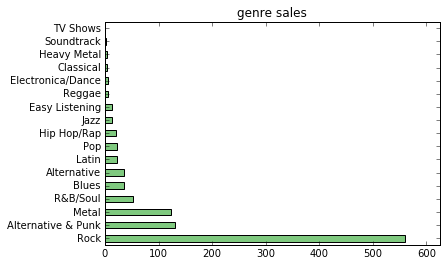

In [7]:
genre=run_query(q1)
genre.set_index("genre",inplace=True)
genre["quantity"].plot.barh(title="genre sales",xlim=(0,625),colormap=plt.cm.Accent)
plt.ylabel(" ")
plt.show()

In [8]:
q2='''WITH emp as
    (
    SELECT * FROM customer c
    INNER JOIN invoice i
    ON i.customer_id=c.customer_id
    )
    SELECT e.first_name||" "||e.last_name employee_name,
    e.hire_date,
    SUM(em.total) sales
    FROM emp em
    INNER JOIN employee e 
    ON e.employee_id=em.support_rep_id
    GROUP BY 1
    ORDER BY sales desc;
'''
run_query(q2)

,employee_name,hire_date,sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


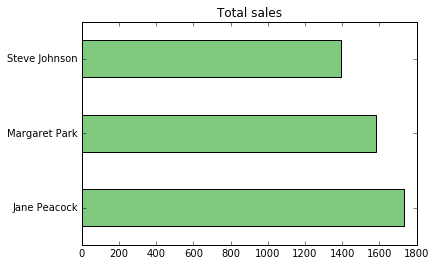

In [9]:
e_sales=run_query(q2)
e_sales.set_index("employee_name",drop=True,inplace=True)
e_sales.plot.barh(legend=False,title="Total sales",colormap=plt.cm.Accent)
plt.ylabel(" ")
plt.show()

* total sales of three different employees tell us that jane has the maximum sales out of the three but we can also see from above cells that jane was hired first of the three and the total sales are directely propotional to the number of time in working for the company.steve is cooping up fast even though he joined 5 months after margaret and 6 months after jane.

In [10]:
q3='''WITH cntry AS
    (
    SELECT c.country,SUM(i.total) total,count(c.customer_id) customers
    FROM customer c INNER JOIN invoice i
    ON i.customer_id=c.customer_id
    GROUP BY 1
    )
    SELECT cn.country,SUM(cn.total) total_sales,
    customers
    FROM cntry cn
    GROUP BY 1
    '''
run_query(q3)

,country,total_sales,customers
0,Argentina,39.60,5
1,Australia,81.18,10
2,Austria,69.30,9
3,Belgium,60.39,7
4,Brazil,427.68,61
5,Canada,535.59,76
6,Chile,97.02,13
7,Czech Republic,273.24,30
8,Denmark,37.62,10
9,Finland,79.20,11


In [11]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    average_customer_sales
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) average_customer_sales,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''
run_query(sales_by_country)

,country,customers,total_sales,average_order,average_customer_sales
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


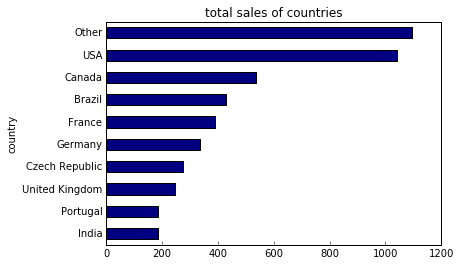

In [12]:
tab=run_query(sales_by_country)
tab.set_index("country",drop=True,inplace=True)
tab.sort_values("total_sales",inplace=True)
x=tab["total_sales"].plot.barh(title="total sales of countries",colormap=plt.cm.gist_ncar)
x.tick_params(top="off", right="off", left="off", bottom="on")
plt.show()

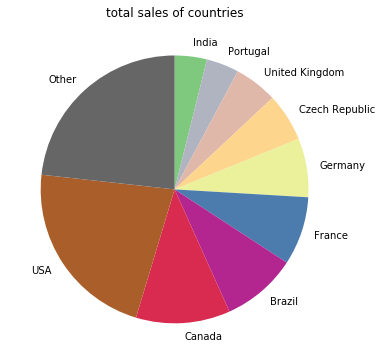

In [13]:
total_sal=tab["total_sales"].copy().rename('')
total_sal.plot.pie(figsize=(6,6),
                   startangle=90,
                   counterclock=False,
                   title="total sales of countries",
                   colormap=plt.cm.Accent,
                   fontsize=10,
                   wedgeprops={'linewidth':0})

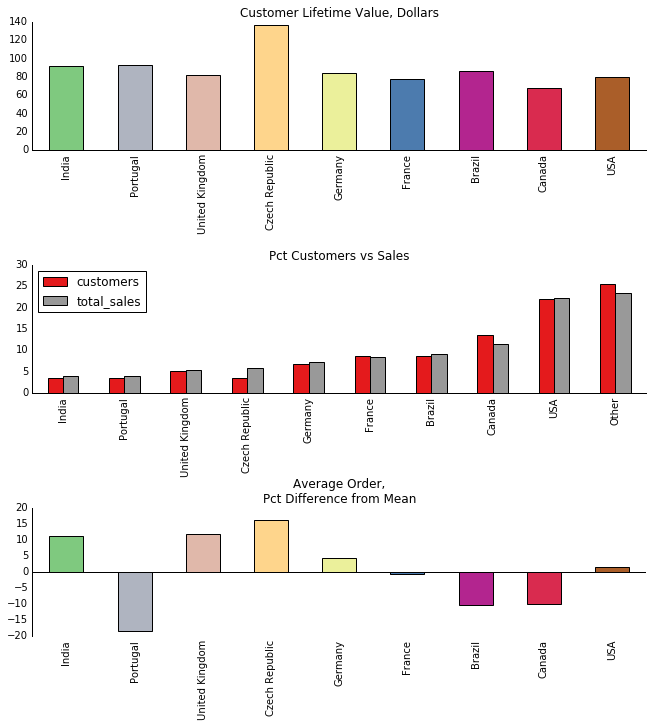

In [14]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(11,11))
ax4, ax2, ax3 = axes.flatten()
fig.subplots_adjust(hspace=.9, wspace=.3)
# 1
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = tab[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# 2
avg_order = tab["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
# 3
ltv = tab["average_customer_sales"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

1. Czech Republic
2. United Kingdom
3. India
<br>It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

In [19]:
query="""WITH cat AS 
        (
        SELECT il.invoice_id invoice_id,
        MIN(il.track_id) first_track
        FROM invoice_line il
        GROUP BY 1
        )
    SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT)/(select count(*) from invoice)
    FROM
    (
    SELECT 
        cat.*,
       CASE 
        WHEN
        (
        SELECT t.track_id FROM track t 
        WHERE t.album_id=
                (select t2.album_id from track t2 
                 where t2.track_id=cat.first_track)
                         
        EXCEPT

        SELECT il2.track_id FROM invoice_line il2
        WHERE il2.invoice_id=cat.invoice_id
        ) IS NULL
        AND
        (
         SELECT il2.track_id FROM invoice_line il2
         WHERE il2.invoice_id=cat.invoice_id
         
        EXCEPT
        
        SELECT t.track_id FROM track t
        WHERE t.album_id=
                (select t2.album_id from track t2
                 where t2.track_id = cat.first_track)
        ) IS NULL
        THEN "yes"
        ELSE "no"
        END AS album_purchase
        FROM cat
        )
        GROUP BY album_purchase
        """
run_query(query)

,album_purchase,number_of_invoices,CAST(COUNT(invoice_id) AS FLOAT)/(select count(*) from invoice)
0,no,500,0.814332
1,yes,114,0.185668


* we can conclude by saying that it is better for the company to just purchase the popular tracks and not the whole album because 81.43 percent of the customers just purchase selected tracks and not the whole album.